In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# Get data

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [3]:
num_classes = metadata.features['label'].num_classes
num_classes

5

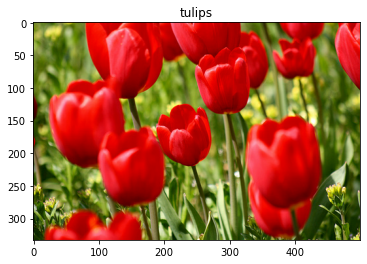

In [4]:
# use this image to demonstrate data augmentation

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# Keras.preprocessing layer

### resizing and rescaling

In [5]:
IMG_SIZE = 180

# create resize and rescale layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255) # rescale pixel values to [0, 1]
])
# if want to rescale to [-1, 1], use Rescaling(1./127.5, offset=-1)

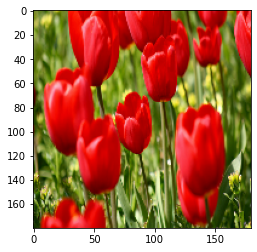

In [6]:
# plot it
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [7]:
# check pixel values
print('Min and max pixel values:', result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [9]:
# add image to a batch
image = tf.expand_dims(image, 0)

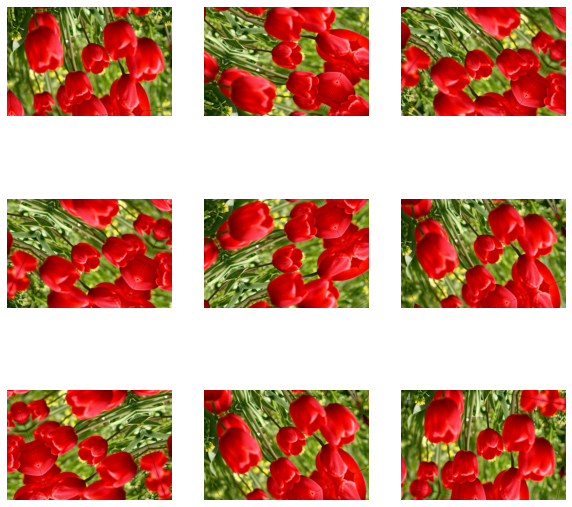

In [10]:
# check some augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [11]:
# data augmentation preprocessing layers can be included in the model
# which get saved and deployed with model, and can also use GPU
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    # rest of the model
])

# or it can be mapped on the dataset
# which can run asynchronously on CPU, while training on GPU, using Dataset.prefetch()
# need to attach preprocessing layers when deploying
aug_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

### map preprocessing layer on dataset

In [14]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # batch all datasets
    ds = ds.batch(batch_size)

    # augment only training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # use buffered prefetch on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### train

In [16]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [18]:
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
92/92 [==============================] - 5s 51ms/step - loss: 1.3459 - accuracy: 0.4121 - val_loss: 1.0895 - val_accuracy: 0.5640
Epoch 2/5
92/92 [==============================] - 4s 44ms/step - loss: 1.0658 - accuracy: 0.5599 - val_loss: 1.0244 - val_accuracy: 0.5586
Epoch 3/5
92/92 [==============================] - 4s 44ms/step - loss: 0.9602 - accuracy: 0.6107 - val_loss: 1.0113 - val_accuracy: 0.6131
Epoch 4/5
92/92 [==============================] - 4s 44ms/step - loss: 0.9118 - accuracy: 0.6366 - val_loss: 0.9002 - val_accuracy: 0.6540
Epoch 5/5
92/92 [==============================] - 4s 44ms/step - loss: 0.8413 - accuracy: 0.6635 - val_loss: 0.9298 - val_accuracy: 0.6240


In [19]:
loss, acc = model.evaluate(test_ds)
print('Accuracy: ', acc)

12/12 [==============================] - 0s 13ms/step - loss: 0.8481 - accuracy: 0.6594
Accuracy:  0.6594005227088928


### custom data augmentation

In [20]:
# create a random invert image color custom augmentation layer

# the function to invert color
def random_invert_image(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

In [21]:
# use layers.Lambda to define custom layer
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_image(x, factor))

random_invert = random_invert()

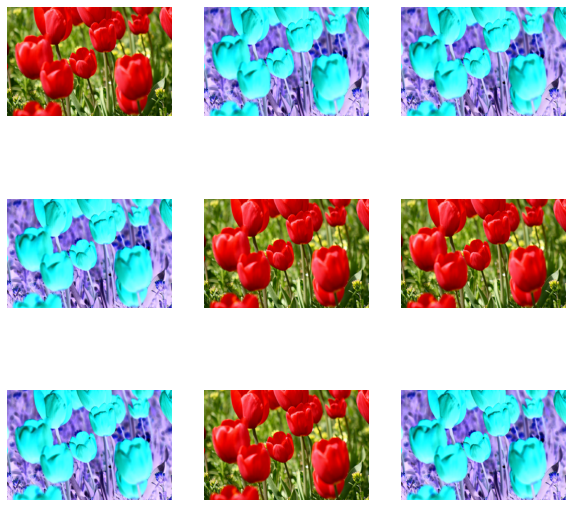

In [22]:
# check the custom layer
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

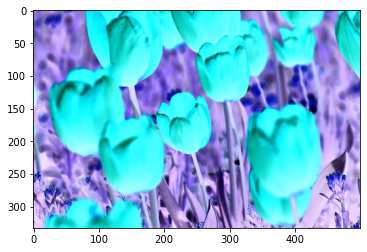

In [23]:
# custom layer can also defined by subclassing layers.Layer class
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
    
    def call(self, x):
        return random_invert_image(x)

_ = plt.imshow(RandomInvert()(image)[0])

# tf.image

In [24]:
# using tf.image can give finer control by writing own data augmentation pipelines or layers

# reimport the dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

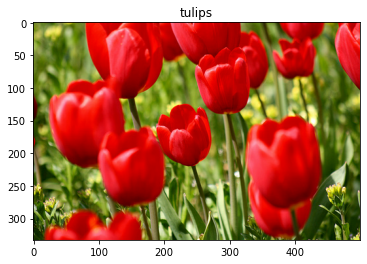

In [25]:
# use this image to demonstrate data augmentation
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [26]:
# function to compare original and augmented image
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(augmented)

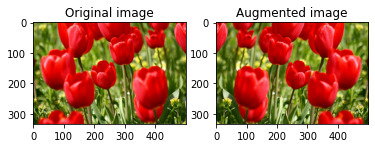

In [27]:
# flip image
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

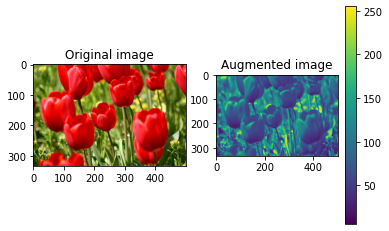

In [28]:
# grayscale
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

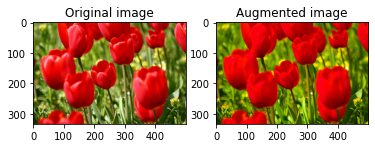

In [29]:
# saturate
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

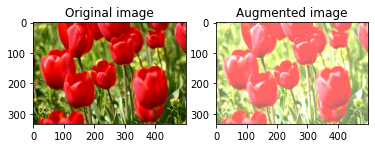

In [30]:
# brightness
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

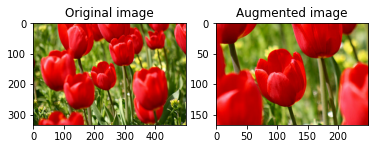

In [31]:
# crop
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

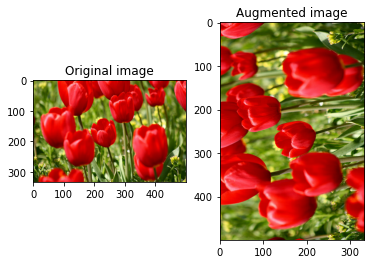

In [32]:
# rotate
rotated = tf.image.rot90(image)
visualize(image, rotated)

### map augmentation to dataset

In [33]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [34]:
def augment(image, label):
    image, label = resize_and_rescale(image, label)
    # add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE+6, IMG_SIZE+6)
    # random crop back to original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    # random brightness
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [35]:
train_ds = train_ds.shuffle(1000).map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
# val and test datasets no shuffle and no augment
val_ds = val_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
test_ds = test_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)